In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import fsolve
import time as time

In [2]:
import algos_QP
import RandomWalk
from RandomWalk import Random_walk

In [3]:
reload(algos_QP)

<module 'algos_QP' from 'algos_QP.pyc'>

# Learning curves

In [48]:
nState=1000
nStep=nState/10

#Transition matrix and reward vector
P_pi,r_pi=Random_walk.compute_policy(nState,nStep)

In [63]:
#First, compute value function in the tabular case
nIter=500
history=True

gamma=0.9

algos=['DP','CG','GD_am','ADAM']
lbl=['Dynamic Programming','Conjugate Gradient','GD w/ momentum','ADAM']

nAlgos=len(algos)
t_algo=np.zeros(nAlgos)
nIter_algo=np.zeros(nAlgos)
err=np.zeros(nAlgos)
v_init=None

if(history):
    v=np.zeros((nAlgos,nIter+1,nState+1))
else:
    v=np.zeros((nAlgos,nState+1))

for algo in enumerate(algos):

    n,t,v_res=algos_QP.compute_valueFunction(
        P_pi,r_pi,discountFactor=gamma,
        algo=algo[1],nIter_max=nIter,x_init_=v_init,
        verbose=True,history=history)

    v[algo[0],:]=v_res
    t_algo[algo[0]]=t
    nIter_algo[algo[0]]=n

n,t,v_TD=algos_QP.compute_valueFunction(
        P_pi,r_pi,discountFactor=gamma,
        algo='Newton',nIter_max=nIter,x_init_=v_init,
        verbose=True,history=False)

#Now, compute errors
if(history):
    err=np.zeros((nAlgos,nIter+1))
    for algo in enumerate(algos):
        err[algo[0],:]=np.max(np.abs(v[algo[0],:]-v_TD),1)

else:
    for algo in enumerate(algos):

        err[algo[0]]=np.max(np.abs(v[algo[0],:]-v_TD))
        print 'Algo:',algo[1], '\t | final error:', err[algo[0]]
        #print 'Algo:',algo[1], '\t | Time:', t_algo[g[0],algo[0]]

Algo: DP 	 | Time (s): 0.0485547267153 	 | #Iter: 176 	 | T/iter: 0.000275879129064
Algo: CG 	 | Time (s): 0.014392597509 	 | #Iter: 23 	 | T/iter: 0.000625765109085
Algo: GD_am 	 | Time (s): 0.214659975618 	 | #Iter: 500 	 | T/iter: 0.000429319951236
Algo: ADAM 	 | Time (s): 0.189479809212 	 | #Iter: 500 	 | T/iter: 0.000378959618423
Algo: Newton 	 | Time (s): 0.0320423971152 	 | #Iter: 1 	 | T/iter: 0.0320423971152


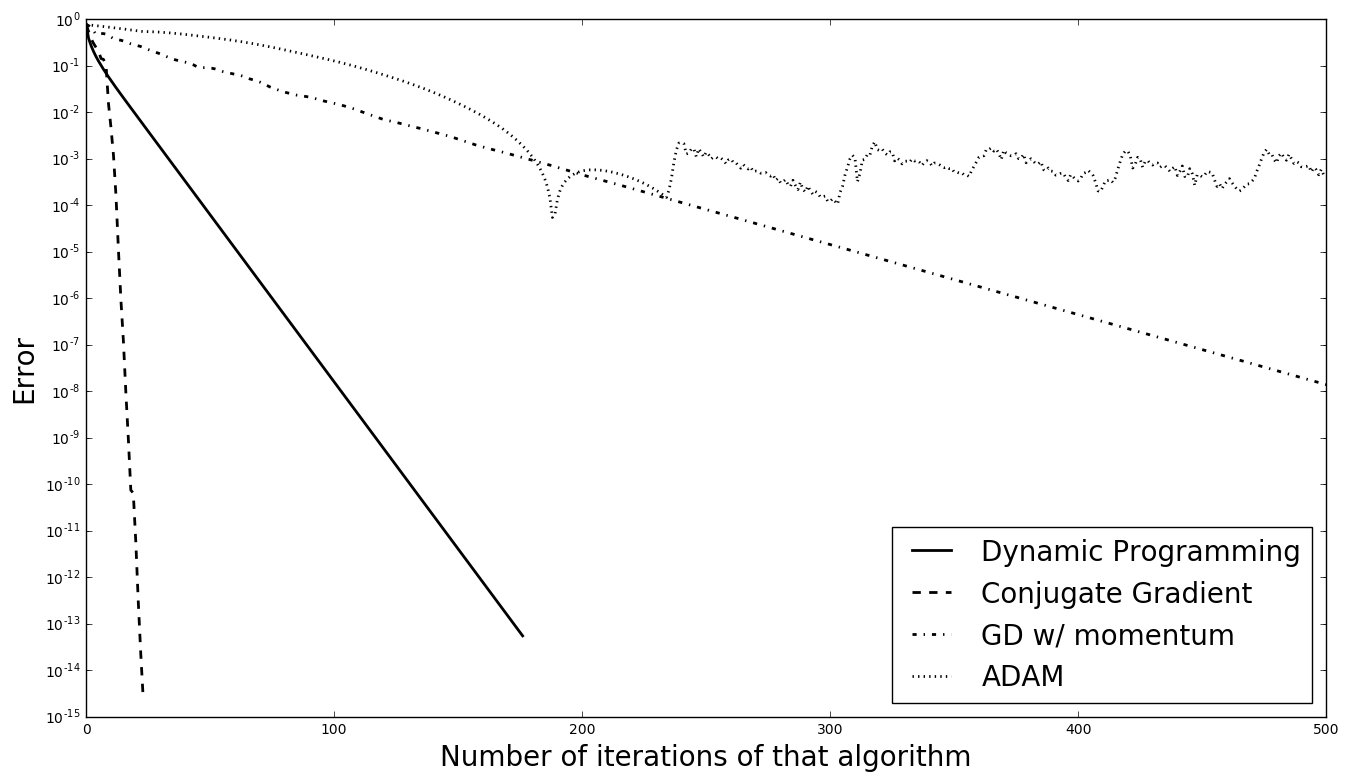

In [66]:
#plot the learning curves
plot_time=False
style=['-','--','-.',':']
plt.figure(figsize=[16,9])
for algo in range(nAlgos):
    if(plot_time):
    
        plt.semilogy((t_algo[algo]/nIter_algo[algo])*np.arange(nIter_algo[algo]+1),err[algo,range(int(nIter_algo[algo]+1))],
                     label=lbl[algo],ls=style[algo%4])
        plt.xlabel('Running time (s)')
    else:
        plt.semilogy(np.arange(nIter_algo[algo]+1),err[algo,range(int(nIter_algo[algo]+1))],
                     label=lbl[algo],ls=style[algo%4],color='k',lw=2)
        #plt.semilogy(err[0,algo,:],label=algos[algo])
        plt.xlabel('Number of iterations of that algorithm',fontsize=20)
    
plt.ylabel('Error',fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.legend(loc=4, fontsize=20)

plt.savefig('C:\Users\Mathieu\Dropbox\PolyMTL\Cours\COMP762 - Reinforcement Learning\Project\Report\images\DPLS_LearningCurve.png', bbox_inches='tight')
plt.show()

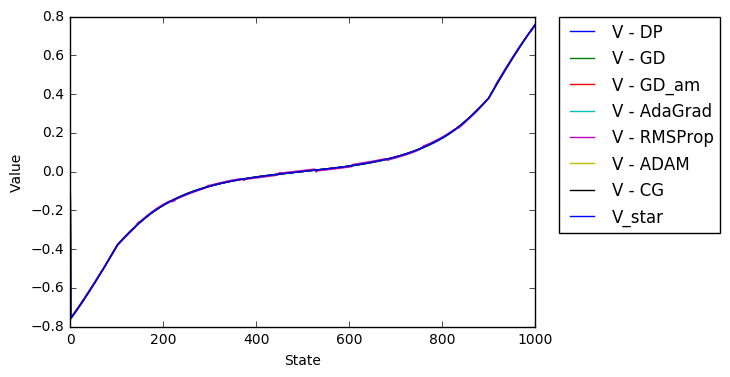

In [7]:
#plot the learned value functions
for algo in range(nAlgos):
    plt.plot(v[algo,nIter,:],label='V - '+algos[algo])

plt.plot(v_TD,label='V_star')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Influence of discount factor $(\gamma)$

In [67]:
nState=1000
nStep=nState/10

#Transition matrix and reward vector
P_pi,r_pi=Random_walk.compute_policy(nState,nStep)

In [68]:
#First, compute value function in the tabular case
nIter=1000
history=False

gamma_=np.array([0.3,0.6,0.9,0.95,0.99,0.995,0.999])

algos=['DP','CG']
lbl=['Dynamic Programming','Conjugate Gradient']

nAlgos=len(algos)
t_algo=np.zeros((gamma_.shape[0],nAlgos))
nIter_algo=np.zeros((gamma_.shape[0],nAlgos))
err=np.zeros((gamma_.shape[0],nAlgos))
v_init=None

if(history):
    v=np.zeros((gamma_.shape[0],nAlgos,nIter+1,nState+1)) 
else:
    v=np.zeros((gamma_.shape[0],nAlgos,nState+1))

for g in enumerate(gamma_):
    print 'gamma=',g[1]
    
    for algo in enumerate(algos):
        
        n,t,v_res=algos_QP.compute_valueFunction(
            P_pi,r_pi,discountFactor=g[1],
            algo=algo[1],nIter_max=nIter,x_init_=v_init,
            verbose=False,history=history)
        
        v[g[0],algo[0],:]=v_res
        t_algo[g[0],algo[0]]=t
        nIter_algo[g[0],algo[0]]=n

    n,t,v_TD=algos_QP.compute_valueFunction(
            P_pi,r_pi,discountFactor=g[1],
            algo='Newton',nIter_max=nIter,x_init_=v_init,
            verbose=False,history=False)

    #Now, compute errors
    if(history):
        err=np.zeros((gamma_.shape[0],nAlgos,nIter+1))
        for algo in enumerate(algos):
            err[g[0],algo[0],:]=np.max(np.abs(v[g[0],algo[0],:]-v_TD),1)

    else:
        for algo in enumerate(algos):
            
            err[g[0],algo[0]]=np.max(np.abs(v[g[0],algo[0],:]-v_TD))
            #print 'Algo:',algo[1], '\t | final error:', err[g[0],algo[0]]
            #print 'Algo:',algo[1], '\t | Time:', t_algo[g[0],algo[0]]

gamma= 0.3
gamma= 0.6
gamma= 0.9
gamma= 0.95
gamma= 0.99
gamma= 0.995
gamma= 0.999


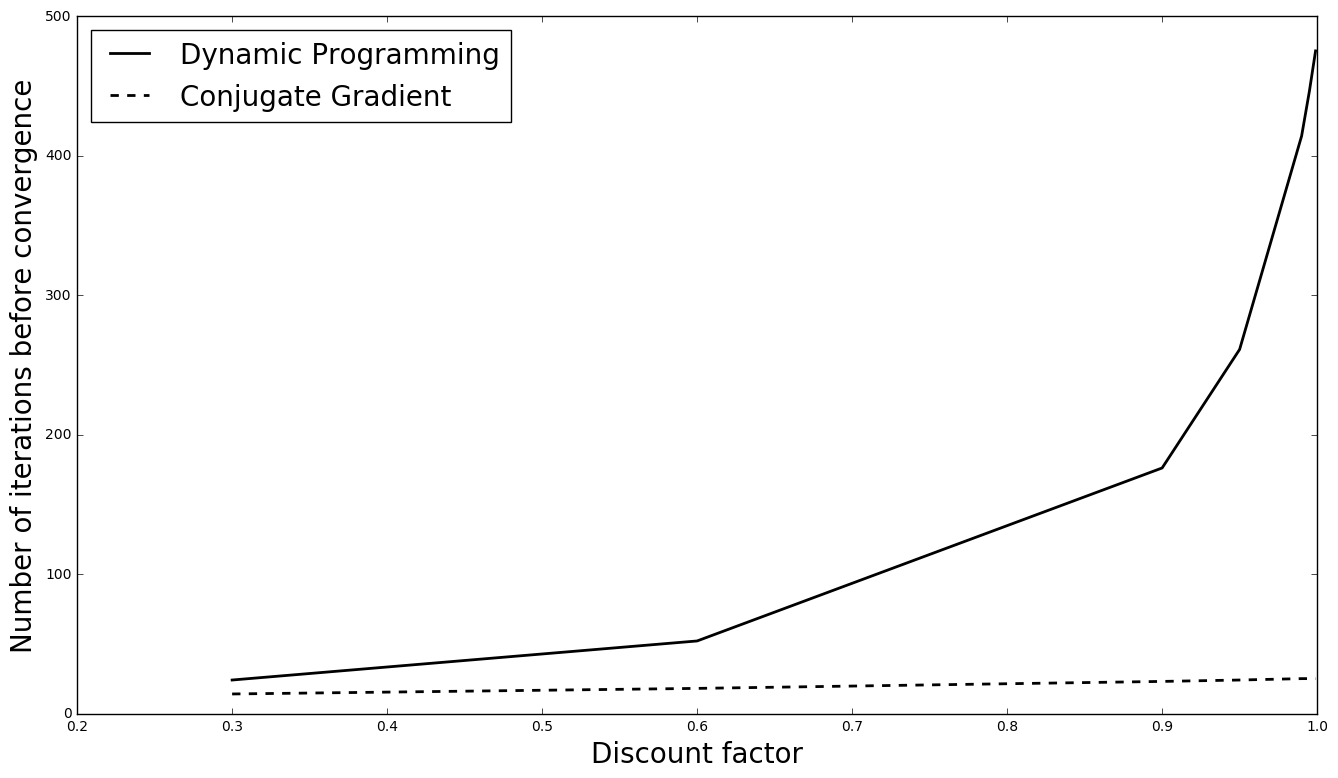

In [69]:
#plot total computation time with respect to gamma
plot_time=False
plt.figure(figsize=[16,9])

for algo in enumerate(algos):
    if(plot_time):

        plt.plot(gamma_,t_algo[:,algo[0]],label=lbl[algo[0]],ls=style[algo[0]],color='k',lw=2)
        plt.ylabel('Solving time',fontsize=20)
    else:
        plt.plot(gamma_,nIter_algo[:,algo[0]],label=lbl[algo[0]],ls=style[algo[0]],color='k',lw=2)
        plt.ylabel('Number of iterations before convergence',fontsize=20)

plt.xlabel('Discount factor',fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.legend(loc=2, fontsize=20)

plt.savefig('C:\Users\Mathieu\Dropbox\PolyMTL\Cours\COMP762 - Reinforcement Learning\Project\Report\images\DPLS_gamma.png', bbox_inches='tight')
plt.show()

# Influence of state space dimension

In [72]:
#First, compute value function in the tabular case
nIter=1000
history=False

nState_=1000*(1+np.arange(10))
gamma=0.9

algos=['DP','CG']
lbl=['Dynamic Programming','Conjugate Gradient']

nAlgos=len(algos)
t_algo=np.zeros((nState_.shape[0],nAlgos))
nIter_algo=np.zeros((nState_.shape[0],nAlgos))
#err=np.zeros((nState_.shape[0],nAlgos))
v_init=None

for nState in enumerate(nState_):
    print 'nState=',nState[1]
    
    P_pi,r_pi=Random_walk.compute_policy(nState[1],nState[1]/5)
    
    
    for algo in enumerate(algos):
        
        n,t,v_res=algos_QP.compute_valueFunction(
            P_pi,r_pi,discountFactor=gamma,
            algo=algo[1],nIter_max=nIter,x_init_=v_init,
            verbose=True,history=history)
        
        #v[nState[0],algo[0],:]=v_res
        t_algo[nState[0],algo[0]]=t
        nIter_algo[nState[0],algo[0]]=n

    #n,t,v_TD=algos_QP.compute_valueFunction(
            #P_pi,r_pi,discountFactor=gamma,
            #algo='Newton',nIter_max=nIter,x_init_=v_init,
            #verbose=False,history=False)
    print '\n'

nState= 1000
Algo: DP 	 | Time (s): 0.0273954348468 	 | #Iter: 94 	 | T/iter: 0.000291440796242
Algo: CG 	 | Time (s): 0.00954528716738 	 | #Iter: 17 	 | T/iter: 0.000561487480434


nState= 2000
Algo: DP 	 | Time (s): 0.126502185432 	 | #Iter: 94 	 | T/iter: 0.00134576793013
Algo: CG 	 | Time (s): 0.0426005551008 	 | #Iter: 17 	 | T/iter: 0.00250591500593


nState= 3000
Algo: DP 	 | Time (s): 0.293731918818 	 | #Iter: 95 	 | T/iter: 0.00309191493492
Algo: CG 	 | Time (s): 0.0977717151191 	 | #Iter: 17 	 | T/iter: 0.00575127735994


nState= 4000
Algo: DP 	 | Time (s): 0.530702260192 	 | #Iter: 95 	 | T/iter: 0.00558633958097
Algo: CG 	 | Time (s): 0.181076011379 	 | #Iter: 18 	 | T/iter: 0.0100597784099


nState= 5000
Algo: DP 	 | Time (s): 0.816469106358 	 | #Iter: 95 	 | T/iter: 0.00859441164588
Algo: CG 	 | Time (s): 0.284727695122 	 | #Iter: 18 	 | T/iter: 0.0158182052846


nState= 6000
Algo: DP 	 | Time (s): 1.17624075902 	 | #Iter: 95 	 | T/iter: 0.0123814816739
Algo: CG 	 | Time 

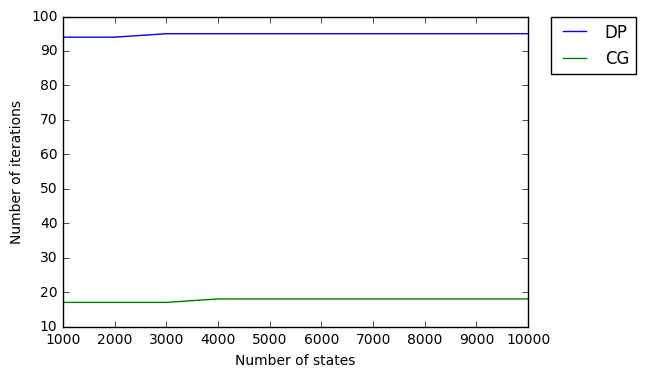

In [90]:
#plot total computation time with respect to n
plot_time=False #choose to display time or number of iterations

for algo in enumerate(algos):
    if(plot_time):
        plt.plot(nState_,t_algo[:,algo[0]],label=algo[1])
        plt.ylabel('Solving time')
    else:
        plt.plot(nState_,nIter_algo[:,algo[0]],label=algo[1])
        plt.ylabel('Number of iterations')

plt.xlabel('Number of states')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.savefig('C:\Users\Mathieu\Dropbox\PolyMTL\Cours\COMP762 - Reinforcement Learning\Project\Presentation\images\DPLS_nState.png', bbox_inches='tight')
plt.show()